In [4]:
!{sys.executable} -m 

Argument expected for the -m option
usage: c:\Users\jonas\AppData\Local\Programs\Python\Python310\python.exe [option] ... [-c cmd | -m mod | file | -] [arg] ...
Try `python -h' for more information.


In [2]:
#Imports 
import pip
import glob, os
from sklearn import svm 
import scipy.io
import numpy as np
from HelperFunctions_ import write_dataset_to_file, split_dataset_paths
import sys 
from spectral import *

import tables as tab
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.semi_supervised import SelfTrainingClassifier



In [3]:
#Finding path names 
Mjosa_data = split_dataset_paths("../Datasets/2022_07_11_Mjosa/2022_07_11_Mjosa/", ["he5", "csv", "jpg"])
Andebu_data = split_dataset_paths("../Datasets/2021_07_21_Andebu/2021_07_21_Andebu/", ["he5", "csv", "jpg"])
Telemark_data = split_dataset_paths("../Datasets/2020_06_23_Telemarkskanalen/2020_06_23_Telemarkskanalen/", ["he5", "csv", "jpg"])


In [4]:
#Amount of dataset should be handled
N_datasets = 2 

#Open files 
open_files_array = []
for i in range(N_datasets):
    file = tab.open_file(Mjosa_data["he5"][i])
    open_files_array.append(file.get_node("/HDFEOS/SWATHS/PRS_L1_HCO/")['Data Fields']['VNIR_Cube'][:,5:,:])

#Load the labels 
load_labels_array = []
for i in range(N_datasets):
    file = Mjosa_data["csv"][i]
    load_labels_array.append(np.loadtxt(file, dtype=np.ubyte))
    



In [9]:
data = open_files_array[0]["0"]
print(data)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [6]:
data = open_files_array[0]
labels = load_labels_array[0]

# prepare data
X = data.transpose(0,2,1).reshape((-1,61))
y = labels.flatten()

X = preprocessing.scale(X, axis=0)                    # Normalization
#X = preprocessing.normalize(X, axis=0)             # Standardization
print(X.shape, y.shape)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.999, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


(1000000, 61) (1000000,)
(1000, 61) (999000, 61) (1000,) (999000,)


In [49]:
#Linear SVM 

# Generate SVM from training data
svma = LinearSVC(max_iter=1e5, tol=1e-5)
svma.fit(X_train, y_train)

c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=100000.0, tol=1e-05)

In [50]:
# calculate overall accuracy on Training data
(svma.predict(X_train)==y_train).sum()/len(y_train)

0.74

In [51]:
# Accuracy on test data
(svma.predict(X_test)==y_test).sum()/len(y_test)

0.7218748748748749

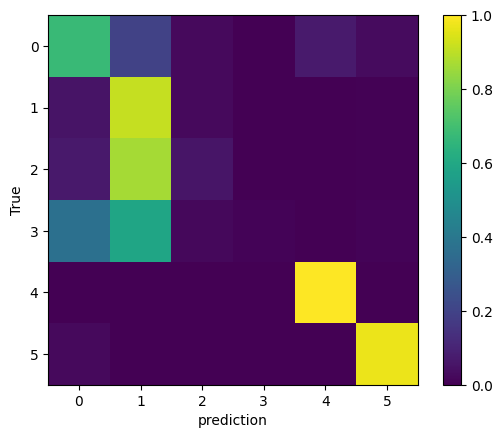

In [53]:
Xout = svma.predict(X)

plt.imshow(Xout.reshape((1000,1000)))

cm = confusion_matrix(labels.flatten(), Xout, normalize='true')

plt.imshow(cm, vmax=1, vmin=0)
plt.ylabel('True')
plt.xlabel('prediction')
plt.colorbar()

In [60]:
svca = SVC(kernel="poly", max_iter=1e4, tol=1e-5)

In [61]:
svca.fit(X_train,y_train)

SVC(kernel='poly', max_iter=10000.0, tol=1e-05)

In [62]:
# calculate overall accuracy on Training data
(svca.predict(X_train)==y_train).sum()/len(y_train)

0.627

In [63]:
# Accuracy on test data
(svca.predict(X_test)==y_test).sum()/len(y_test)

0.6502942942942943

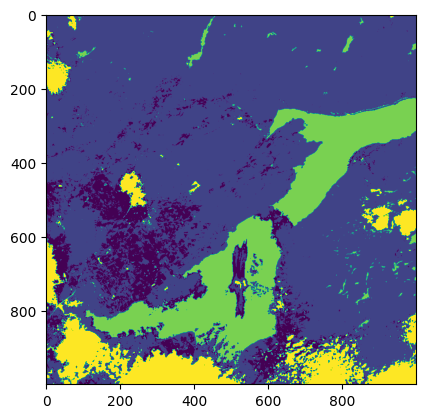

In [65]:
Xout = svca.predict(X)

plt.imshow(Xout.reshape((1000,1000)))

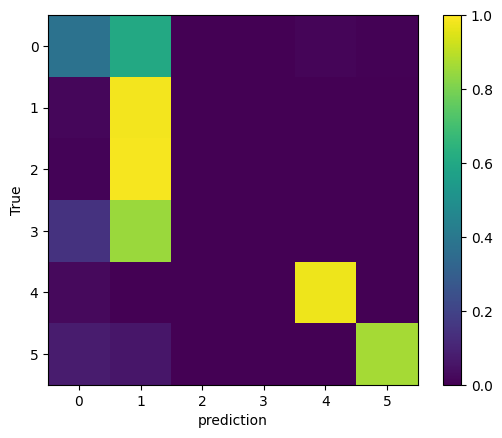

In [66]:
cm = confusion_matrix(labels.flatten(), Xout, normalize='true')

plt.imshow(cm, vmax=1, vmin=0)
plt.ylabel('True')
plt.xlabel('prediction')
plt.colorbar()

In [98]:
tree = DecisionTreeClassifier(random_state=10)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=10)

In [99]:
# calculate overall accuracy on Training data
(tree.predict(X_train)==y_train).sum()/len(y_train)

1.0

In [100]:
# Accuracy on test data
(tree.predict(X_test)==y_test).sum()/len(y_test)

0.6666276276276276

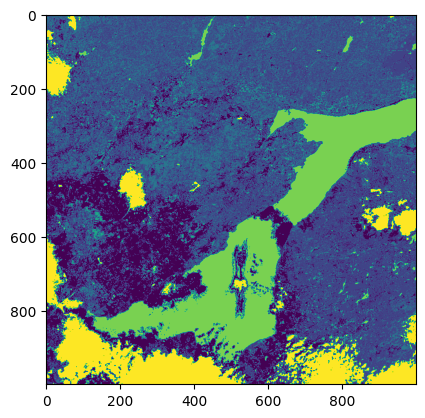

In [101]:

Xout = tree.predict(X)

plt.imshow(Xout.reshape((1000,1000)))

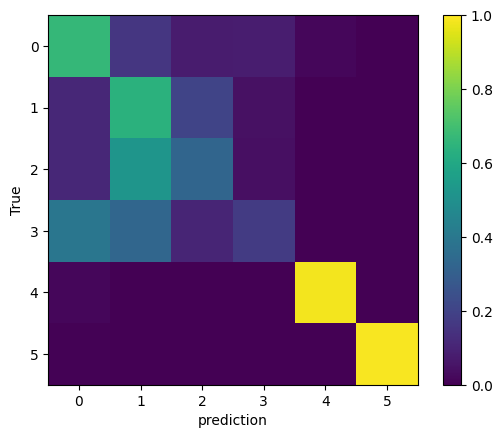

In [102]:
cm = confusion_matrix(labels.flatten(), Xout, normalize='true')

plt.imshow(cm, vmax=1, vmin=0)
plt.ylabel('True')
plt.xlabel('prediction')
plt.colorbar()

In [92]:
#svc = SVC(kernel="rbf", max_iter=1e5, tol=1e-5)
#svc.fit(X_train, y_train)
tree = DecisionTreeClassifier(random_state=10)
tree.fit(X_train, y_train)
self_training_model = SelfTrainingClassifier(base_estimator=tree)
self_training_model.fit(X_train,y_train)

c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\semi_supervised\_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


SelfTrainingClassifier(base_estimator=DecisionTreeClassifier(random_state=10))

In [93]:
# calculate overall accuracy on Training data
(self_training_model.predict(X_train)==y_train).sum()/len(y_train)

1.0

In [94]:
# Accuracy on test data
(self_training_model.predict(X_test)==y_test).sum()/len(y_test)

0.6666276276276276

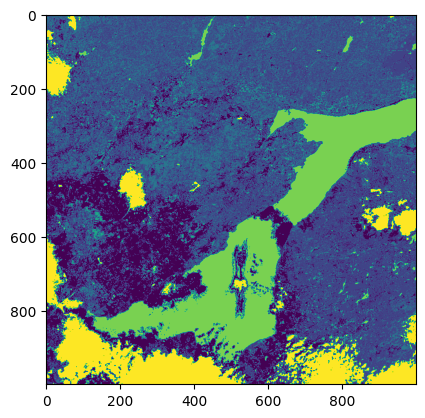

In [95]:
Xout = self_training_model.predict(X)

plt.imshow(Xout.reshape((1000,1000)))

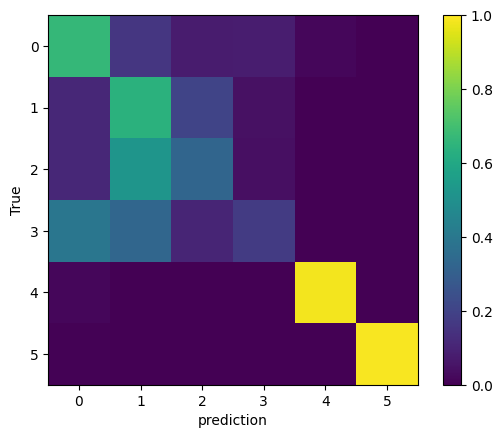

In [96]:
cm = confusion_matrix(labels.flatten(), Xout, normalize='true')

plt.imshow(cm, vmax=1, vmin=0)
plt.ylabel('True')
plt.xlabel('prediction')
plt.colorbar()